決策樹如同 SVM 一樣，也是一種多功能的機器學習算法，可以實現分類和迴歸，甚至是多輸出任務，能夠擬合複雜的數據集。決策樹同時是隨機森林的基本組成部份。

**在決策樹中，最能區分類别的特徵將作為最先判斷的條件，然後依次向下判斷各個次優特徵**。決策樹的核心就在於如何選取每個節點的最優判斷條件，也即特徵選擇的過程。而在每一個判斷節點，決策樹都會遵循一套 if-then 的規則。

# Training and Visualizing a Decision Tree

以下是在鳶尾花數據集上訓練一個 DecisionTreeClassifier。

In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(42)

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [3]:
iris = load_iris()
X = iris.data[:, 2:]       # petal length and width
y = iris.target

In [4]:
tree_clf = DecisionTreeClassifier(max_depth = 2)

In [5]:
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

要將決策樹結果可視化，先使用 export_graphviz() 輸出一個圖形定義文件 .dot，再使用 *graphviz* 中的 dot 命令工具將這個 .dot 文件轉換為其他格式，如 PDF 或 PNG。

In [6]:
from sklearn.tree import export_graphviz

In [7]:
export_graphviz(
                tree_clf,
                out_file = './iris_tree.dot',
                feature_names = iris.feature_names[2:], 
                class_names = iris.target_names,
                rounded = True, 
                filled = True
)

In [8]:
! dot -Tpng iris_tree.dot -o iris_tree.png

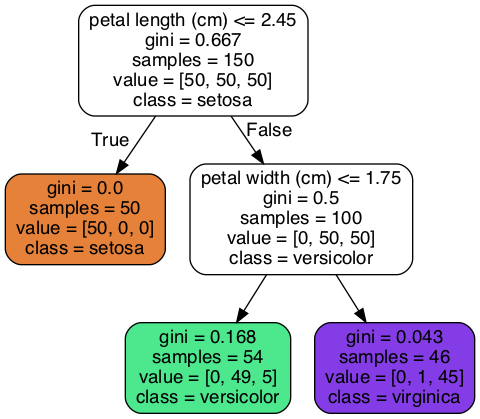

# Making Predictions

由上圖中可以看出樹是如何進行預測的。

想要對鳶尾花進行分類。就從跟節點（深度0，頂部）開始來判定條件是否符合，
    
    * 如果符合，則向下移動到根的左側子節點（深度1，左）。在這例子中，它是一個葉節點（即没有任何子節點），因此它不再繼續提出問題，可以直接查看該節點的預測類別。

    * 如果不符合，則向下移動到根的右側子節點（深度1，右），該節點不是一個葉節點，所以它提出另外一個問題：
    
          * 如果是，那可能是左側的類別（深度2，左）。
    
          * 如果不是，很可能是右側的類別（深度2，右）。

決策樹的許多特性之一是它們需要的數據準備工作很少。特别是，**根本不需要進行特徵縮放或集中**。

1. 節點的 **samples** 屬性統計它應用的訓練實例數量。

2. 節點的 **value** 屬性說明該節點上每個類別的訓練實例數。

3. 最後，節點的 **gini** 屬性測量其 **不純度（impurity）**：如果應用的所有訓練實例都屬於同一個類別，則該節點就是“純”的（gini = 0）。 

以下公式說明了第 i 個節點的 **吉尼係數（gini）$G_i$** 的計算方式。 

$$ G_i = 1 - \sum_{i = 1}^n p_{i, k}^2 $$

$p_{i, k}$ 是第 $i$ 個節點上，類別為 $k$ 的訓練實例佔比。


例如，上圖中深度為 2 的左結點的 **gini** 等於 $ 1 - (0/54)^2 - (49/54)^2 - (5/54)^2≈0.168$。 

Scikit-Learn 使用 CART 算法，該算法僅生成二叉樹：非葉節點永遠只有兩個子節點（即問題答案僅有是或否）。 但是，其他算法，比如 ID3 生成的決策樹，其節點可以擁有兩個以上的子節點。

In [9]:
from matplotlib.colors import ListedColormap

In [10]:
def plot_decision_boundary(clf, X, y, axes = [0, 7.5, 0, 3], iris = True, legend = False, plot_training = True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha = 0.3, cmap = custom_cmap)
    
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap = custom_cmap2, alpha = 0.8)
        
    if plot_training:
        plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'yo', label = 'Iris-Setosa')
        plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs', label = 'Iris-Versicolor')
        plt.plot(X[:, 0][y == 2], X[:, 1][y == 2], 'g^', label = 'Iris-Virginica')
        plt.axis(axes)
        
    if iris:
        plt.xlabel('Petal length', fontsize = 14)
        plt.ylabel('Petal width', fontsize = 14)
    else:
        plt.xlabel(r'$x_1$', fontsize = 18)
        plt.ylabel(r'$x_2$', fontsize = 18, rotation = 0)
        
    if legend:
        plt.legend(loc = 'lower right', fontsize = 14)

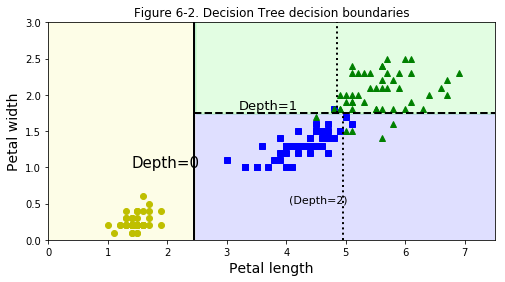

In [11]:
plt.figure(figsize = (8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], 'k-', linewidth = 2)
plt.plot([2.45, 7.5], [1.75, 1.75], 'k--', linewidth = 2)
plt.plot([4.95, 4.95], [0, 1.75], 'k:', linewidth = 2)
plt.plot([4.85, 4.85], [1.75, 3], 'k:', linewidth = 2)
plt.text(1.40, 1.0, 'Depth=0', fontsize = 15)
plt.text(3.2, 1.80, 'Depth=1', fontsize = 13)
plt.text(4.05, 0.5, '(Depth=2)', fontsize = 11)
plt.title('Figure 6-2. Decision Tree decision boundaries')

plt.show()

上圖顯示了決策樹的決策邊界。

* **粗垂直線**表示根節點（深度0）的決策邊界：花瓣長度 = 2.45厘米。因為左側區域是純的（只有 Iris-Setosa），因此它不可再分。 

* 但，右側區域是不純的，因此深度 1 右側的節點在花瓣寬度 = 1.75厘米（**虛線**表示）再次分裂。因為 max_depth 設置為 2，所以決策樹在此停止。 

* 但是，如果將 max_depth 設置為 3，那兩個深度為 2 的節點將各自再產生一條決策邊界（**點虛線**表示）。

**Model Interpretation: White Box Versus Black Box**

**決策樹非常直觀**，其決策很容易解釋。 這種模型通常被稱為**白盒模型（white box models）**。與之相反的，像**隨機森林或神經網路**通常被認為是**黑盒模型（black box models）**。 可以做出了很好的預測，可以輕鬆地檢查它們在做出預測時執行的計算；但通常很難用簡單的術語解釋為什麼做出預測。

# Estimating Class Probabilities

決策樹也可以估算某個實例屬於特定類別 $k$ 的機率，先隨決策樹找到該實例的葉節點，之後返回該節點中類別 $k$ 的訓練實例佔比。輸出機率最高的當作該類別。

In [11]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [12]:
tree_clf.predict([[5, 1.5]])

array([1])

# The CART Training Algorithm

Scikit-Learn 使用的是*分類與迴歸樹（Classification And Regression Tree, CART）*算法來訓練決策樹（also called “growing” trees）。

首先，使用單個特徵 $k$ 和閾值 $t_k$ 將訓練集分成兩個子集。$k$ 和閾值 $t_k$ 的選擇是利用產生出最純子集（受其大小加權）的 $k$ 和 $t_k$ 就是精算法搜尋確定的 $(t, t_k)$。算法嘗試最小化的成本函數為以下公式。

**CART cost function for classification：**

$$ J(k, t_k) = \frac{m_{left}}{m}G_{left} + \frac{m_{right}}{m}G_{right} $$

$$ where \begin{cases} G_{left/right} & measures \; the \;impurity\; of\; the\; left/right\; subset, \cr m_{left/right} & is\; the\; number\; of\; instances\; in\; the\; left/right\; subset. \end{cases} $$

成功將訓練集一分為二後，就使用相同的邏輯，繼續分裂子集，然後是子集的子集，依次循環進行，直到最大深度（由超參數 max_depth 控制），或是再也找不到能夠降低不純度的分裂，才會停止。另外還有一些超參數可以用來控制附加的停止條件（min_samples_split, min_samples_left, min_weight_fraction_leaf 及 max_leaf_nodes）。

CART 是一種貪婪算法，從頂層開始搜尋最優分裂，之後每層重複該過程。幾層分裂之後，並不會檢視這個分裂的不存度是否為可能的最低值。貪婪算法通常會產生一個相當不錯的解，但不能保證是最優解。

尋找最優樹是一個已知 **NP-Complete problem**：需要的時間是 $O(exp(m))$，所以即使是很小的訓練集，問題也難以處理。這也是為什麼必須接受一個“相當不錯的解”。

P 就是能在多項式時間內解決的問題集。NP 是能在多項式時間內驗證解正確與否的問題集。NP-Hard 問題是在多項式時間內可以減少任何 NP 問題的問題。 NP-Complete problem 是 NP 和 NP-Hard。一個主要的開放數學問題是 P 是否等於 NP。 如果 P≠NP（似乎很可能），則不存在多項式算法（可能量子計算機除外）。

# Computational Complexity

進行預測需要從根到葉遍歷決策樹。遍歷決策樹需要經歷大約 $O(log_2(m))$ 個節點。每個節點只需要檢查一個特徵值，所以整體預測複雜度也只是 $O(log_2(m))$，與特徵數量無關。因此，即便是處理大型數據集，預測也很快。

$log_2$ 是以 2 為底的對數。等於 $log_2(m) = log(m)/log(2)$。

但，訓練時在每一個節點，算法都需要在所有樣本上比較所有特徵（如果設置了 max_features 會少一些）。這會導致訓練的複雜度為 $O(n \times m \; log(m))$。對於小型訓練集（幾千個實例以內），Scikit-Learn 可以透過對數據預處理（設置 presort = True）來加快訓練，但對於較大訓練集而言，可能會減慢訓練的速度。

# Gini Impurity or Entropy?

預測使用的是 Gini Impurity，但可以將超參數 criterion 設置為 **“entropy“** 選擇*信息熵（entropy）*作爲不純度的測量方式。

熵是源自熱力學，是一種分子混亂程度的度量，如果分子保持靜止或良序，則熵接近於 0。應用到各領域中，在 Shannon’s information theory，衡量的是一條訊息的平均訊息內容：如果所有的訊息都相同，則熵為 0（it measures the average information content of a message: entropy is zero when all messages are identical）。在機器學習中，也被用作一種不純度的測量方式：如果數據集中僅包含一種類別的實例，其熵為 0。

以下公式顯示第 $i$ 個節點的熵值的計算方式。

**Entropy：**

$$ H_i = - \sum_{\underset{p_{i,k} \ne 0}{k = 1}}^n p_{i,k} log(p_{i, k}) $$

在 'Figure 6-2. Decision Tree decision boundaries' 中，深度 2 左側節點的熵值等於 $- \frac{49}{54}log \left(\frac{49}{54}\right)- \frac{5}{54} log\left(\frac{5}{54}\right) \approx 0.31$

在大多數情況下，Gini Impurity 和 Entropy 並沒有多大不同，產生的樹都很相似。Gini Impurity 的計算速度略稍快一些，是不錯的預設選擇。不同在於，Gini Impurity 傾向於從樹枝中分裂出最常見的類別，而 Entropy 則傾向於生產更平衡的樹。

# Regularization Hyperparameters

決策樹極少對訓練數據做出假设（與線性模型假設數據是線性的相反）。如果不加以限制，樹的結構將跟隨訓練集變化，嚴密擬合，並且很可能過度擬合。這種模型通常被稱為**非参數模型**，不是因為它没有任何參數（事實上它通常有很多參數），**而是指在訓練之前沒有確定參數的數量**，導致模型結構自由而緊密地貼近數據。 相比之下，如線性模型，則有預先設定好的一部分參數，因此其自由度受到限制，從而降低了過擬合的風險（但增加了欠擬合的風險）。

為避免過擬合訓練數據，需要在訓練過程中**降低決策樹的自由度**。這個過程稱為**正則化**。正則化超參數的選擇取決於所使用的模型，但通常，至少可以**限制決策樹的最大深度**。 在 Scikit-Learn 中，這由**超參數 max_depth** 控制（預設值為 None，表示無限制）。**減少 max_depth 可使模型正則化，從而降低過度擬合的風險**。

**DecisionTreeClassifier** 還有一些其他參數，同樣可以類限制決策樹的形状：

* min_samples_split（分裂前節點必須有的最小樣本數）

* min_samples_leaf（葉節點必須有的最小樣本數量）

* min_weight_fraction_leaf（與 min_samples_leaf 相同，但表現為加權實例總數的佔比）

* max_leaf_nodes（最大葉節點數量）

* max_features（分裂每個節點評估的最大特徵數量）

增大超參數 min_*  或減少超參數 max_* 將使模型正則化

其他演算法還有一開始訓練決策樹是不約束，之後再對不必要的節點進行剪枝（删除）。如果一個節點的子節點全部為葉節點，則該節點可被認為不必要，除非它所表示的純度提升有重要的統計意義。標準統計測試，例如 $χ^2$ 測試，是用來估算“提升純粹是出於偶然”（被稱為虛假設 null hypothesis）的機率。如果這個機率（稱為 p value）高於給定閾值（通常為 5％，由超參數控制），那麼該節點可被認為不必要，其子節點可被删除。修剪繼續，直到所有不必要的節點都被刪除，剪枝過程結束。

In [13]:
from sklearn.datasets import make_moons

In [14]:
Xm, ym = make_moons(n_samples = 100, noise = 0.25, random_state = 53)

In [15]:
deep_tree_clf1 = DecisionTreeClassifier(random_state = 42)

In [16]:
deep_tree_clf1.fit(Xm, ym)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [17]:
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf = 4, random_state = 42)

In [18]:
deep_tree_clf2.fit(Xm, ym)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

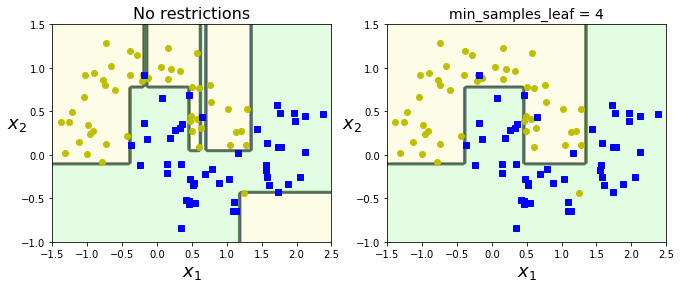

In [19]:
plt.figure(figsize = (11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes = [-1.5, 2.5, -1, 1.5], iris = False)
plt.title('No restrictions', fontsize = 16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes = [-1.5, 2.5, -1, 1.5], iris = False)
plt.title('min_samples_leaf = {}'.format(deep_tree_clf2.min_samples_leaf), fontsize = 14)

plt.show()

上圖顯示了在 moons datasets 上訓練的兩個決策樹。在左側，使用預設參數（即没有限制）來訓練決策樹，在右側的決策樹使用 min_samples_leaf = 4 進行訓練。很明顯，左圖模型過度擬合，右圖的模型泛化效果更佳。

# Regression

決策樹也可執行迴歸任務。用 Scikit_Learn 的 DecisionTreeRegressor 來建構一個迴歸樹。

在一個帶有雜訊的二次數據集上進行訓練，其中 max_depth = 2

In [20]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [21]:
from sklearn.tree import DecisionTreeRegressor

In [22]:
tree_reg = DecisionTreeRegressor(max_depth = 2)

In [23]:
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [24]:
from sklearn.tree import export_graphviz

In [25]:
export_graphviz(
        tree_reg,
        out_file = './regression_tree.dot',
        feature_names = ['x1'],
        rounded = True,
        filled = True
    )

In [26]:
! dot -Tpng regression_tree.dot -o regression_tree.png

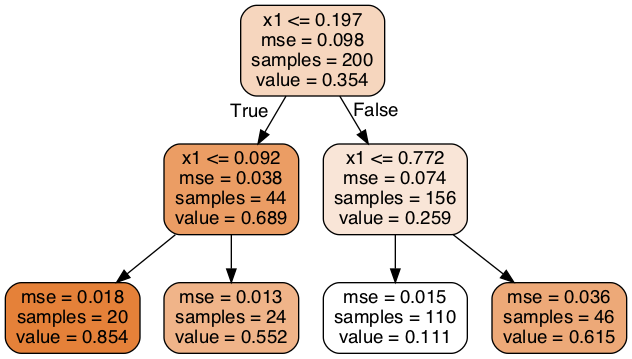

這棵樹與之前建立的分類數很類似，主要差別在於，每個節點上不再是預測一個類別，而是預測一個值。

例如，想對一個 $x_1 = 0.6$ 的新實例進行預測，從根節點開始遍歷，最後到達預測 value = 0.111 的葉節點。這個預測結果其實就是與這個夜節點關聯的 110 個實例的平均目標值。在這 110 個實例上，預測產生的均方誤差（MSE）等於 0.015。

In [27]:
from sklearn.tree import DecisionTreeRegressor

In [28]:
tree_reg1 = DecisionTreeRegressor(random_state = 42, max_depth = 2)

In [29]:
tree_reg2 = DecisionTreeRegressor(random_state = 42, max_depth = 3)

In [30]:
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [31]:
tree_reg2.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [32]:
def plot_regression_predictions(tree_reg, X, y, axes = [0, 1, -0.2, 1], ylabel = '$y$'):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    
    plt.axis(axes)
    plt.xlabel('$x_1$', fontsize = 18)
    
    if ylabel:
        plt.ylabel(ylabel, fontsize = 18, rotation = 0)
    
    plt.plot(X, y, 'b.')
    plt.plot(x1, y_pred, 'r.-', linewidth = 2, label = r'$\hat{y}$')

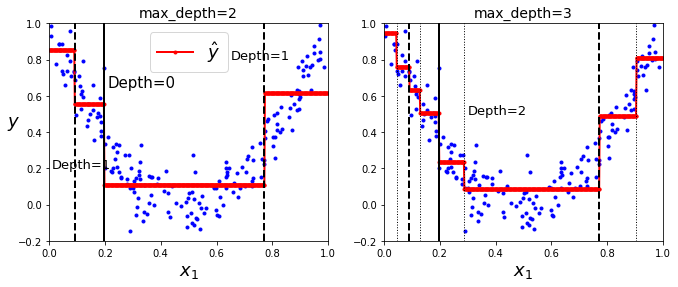

In [33]:
plt.figure(figsize = (11, 4))
plt.subplot(121)

plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, 'k-'), (0.0917, 'k--'), (0.7718, 'k--')):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, 'Depth=0', fontsize = 15)
plt.text(0.01, 0.2, 'Depth=1', fontsize = 13)
plt.text(0.65, 0.8, 'Depth=1', fontsize = 13)
plt.legend(loc = 'upper center', fontsize = 18)
plt.title('max_depth=2', fontsize = 14)

plt.subplot(122)

plot_regression_predictions(tree_reg2, X, y, ylabel = None)
for split, style in ((0.1973, 'k-'), (0.0917, 'k--'), (0.7718, 'k--')):
    plt.plot([split, split], [-0.2, 1], style, linewidth = 2)
    
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], 'k:', linewidth = 1)
    
plt.text(0.3, 0.5, 'Depth=2', fontsize = 13)
plt.title('max_depth=3', fontsize = 14)

plt.show()

上圖的左側顯示了該模型的預測。如果設置 max_depth = 3，將得到如右側所示的預測。每個區域的預測值永遠等於該區域內實例的目標平均值。算法分裂每個區域的方法，就是使最多的訓練實例盡可能接近這個預測值。

CART 算法的工作原理和前面介紹的大致相同，唯一不同是，分裂訓練集的方式不是最小化不純度，而是最小化 MSE。

以下公式顯示了算法嘗試最小化的成本函數。

**CART cost function for regression：**

$$ J(k, t_k) = \frac{m_{left}}{m}MSE_{left} + \frac{m_{right}}{m}MSE_{right} $$

$$ where \begin{cases} MSE_{node} = \sum_{i\in node}(\hat y_{node} - y^{(i)})^2 \cr \hat y_{node} = \frac{1}{m_{node}}\sum_{i \in node} y^{(i)} \end{cases} $$

In [34]:
tree_reg1 = DecisionTreeRegressor(random_state = 42)

In [35]:
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [36]:
tree_reg2 = DecisionTreeRegressor(random_state = 42, min_samples_leaf = 10)

In [37]:
tree_reg2.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [38]:
x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

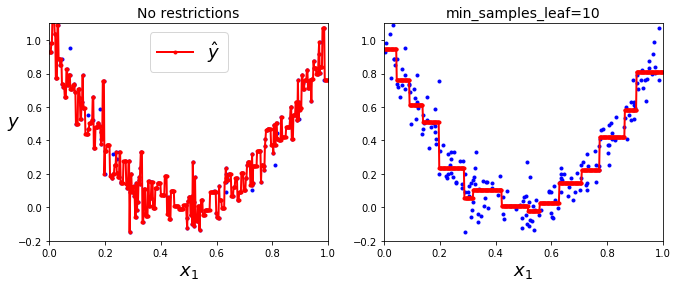

In [39]:
plt.figure(figsize = (11, 4))

plt.subplot(121)
plt.plot(X, y, 'b.')
plt.plot(x1, y_pred1, 'r.-', linewidth = 2, label = r'$\hat{y}$')
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel('$x_1$', fontsize = 18)
plt.ylabel('$y$', fontsize = 18, rotation = 0)
plt.legend(loc = 'upper center', fontsize = 18)
plt.title('No restrictions', fontsize = 14)

plt.subplot(122)
plt.plot(X, y, 'b.')
plt.plot(x1, y_pred2, 'r.-', linewidth = 2, label = r'$\hat{y}$')
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel('$x_1$', fontsize = 18)
plt.title('min_samples_leaf={}'.format(tree_reg2.min_samples_leaf), fontsize = 14)

plt.show()

與分類任務一樣，決策樹在處理迴歸任務時容易過度擬合。如果沒有任何正則化（即使用預設的超參數），將得到上圖左側的預測結果。 這顯然對訓練集嚴重過度擬合。只需要設置 min_samples_leaf = 10 ，就可得到一個較為合理的模型，如上圖右側所示。

# Instability

選擇決策樹主要是因為它們很容易理解和解釋，使用簡單，功能全面且十分強大。但也還是有些限制，首先，決策樹青睞正交的決策邊界（所有的分裂都與軸線垂直），這導致對訓練集的旋轉非常敏感。

In [40]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

In [41]:
angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

In [42]:
tree_clf_s = DecisionTreeClassifier(random_state = 42)

In [43]:
tree_clf_s.fit(Xs, ys)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [44]:
tree_clf_sr = DecisionTreeClassifier(random_state = 42)

In [45]:
tree_clf_sr.fit(Xsr, ys)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

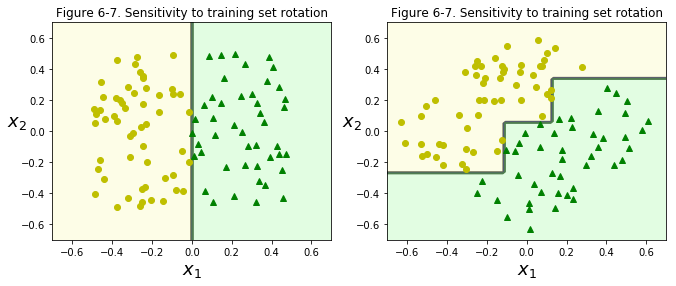

In [46]:
plt.figure(figsize = (11, 4))

plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes = [-0.7, 0.7, -0.7, 0.7], iris = False)
plt.title('Figure 6-7. Sensitivity to training set rotation')

plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes = [-0.7, 0.7, -0.7, 0.7], iris = False)
plt.title('Figure 6-7. Sensitivity to training set rotation')

plt.show()

上圖顯示了一個簡單的線性可分離數據集，左圖中，決策樹可以很容易的分割，到了右圖，數據集旋轉了45度後，決策邊界產生了不必要的捲曲。雖然兩個模型都看似完美擬和訓練集，但右側模型很可能泛化不佳。限制這個問題的方法之一就是使用 PCA，讓訓練數據定位在一個更好的方向上。

決策樹的主要問題是對訓練數據中的小變化非常敏感。

從鳶尾花數據集中移除花瓣最寬的 Versicolor 鳶尾花（花瓣長 4.8 厘米，寬 1.8 厘米），然後重新訓練一個決策樹，可能得到如下圖所示的模型。這結果和先前（’Figure 6-2. Decision Tree decision boundaries‘）的決策樹看起來相當不同。

In [47]:
iris = load_iris()
X = iris.data[:, 2:]       # petal length and width
y = iris.target

In [48]:
X[(X[:, 1] == X[:, 1][y == 1].max()) & (y == 1)]         # widest Iris-Versicolor flower

array([[4.8, 1.8]])

In [49]:
not_widest_versicolor = (X[:, 1] != 1.8) | (y == 2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

In [50]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth = 2, random_state = 40)

In [51]:
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=40,
            splitter='best')

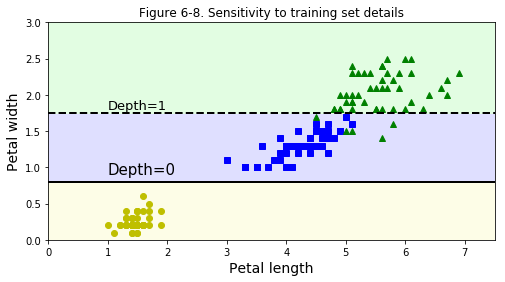

In [52]:
plt.figure(figsize = (8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend = False)
plt.plot([0, 7.5], [0.8, 0.8], 'k-', linewidth = 2)
plt.plot([0, 7.5], [1.75, 1.75], 'k--', linewidth = 2)
plt.text(1.0, 0.9, 'Depth=0', fontsize = 15)
plt.text(1.0, 1.80, 'Depth=1', fontsize = 13)
plt.title('Figure 6-8. Sensitivity to training set details')

plt.show()

由於 Scikit-Learn 使用的訓練算法是隨機的，即使在相同的訓練數據上，也可能得到完全不同的模型（除非對超參數 random_state 進行設置）。

作者在 github 中新增的程式，書中沒有的。

In [53]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

In [54]:
tree_clf_r = DecisionTreeClassifier(random_state = 42)

In [55]:
tree_clf_r.fit(Xr, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

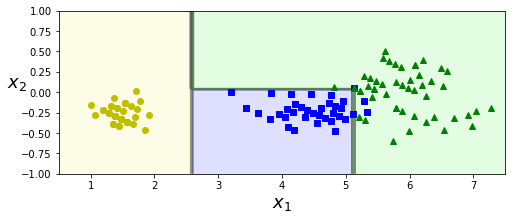

In [56]:
plt.figure(figsize = (8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes = [0.5, 7.5, -1.0, 1], iris = False)

plt.show()

# 心得

決策樹是很簡單且容易的演算法，在一些簡單的資料集中，處理分類問題就可以有很好的效果，且對於結果的解釋上也比較直觀，解釋性也高。可以說是處理分類問題的入門款。作者在這邊除了分類問題外，也提及到的迴歸問題，說明了在這兩種問題上，決策樹的不同之處。也對 Scikit-Learning 中的 DecisionTreeClassifier 所使用的超參數有些說明，這在實際上操作上，可以有明確的認知，當參數值不同時會有怎樣的結果，或是要達到想要的結果時，可以利用超參數的改變來達成。整體上對於決策樹有更深的體會與體認。